# Librerias

**Para replicar los gráficos solo hace falta importar las librerías y bajar hasta el final en donde se encuetra la sección de plots**


In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np
import os
#
from PIL import Image

import time
from sklearn.decomposition import PCA
# from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression as mutual_inf
from sklearn.feature_selection import mutual_info_classif as mutual_int
import glob

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
# SAVE_PATH = "" #Local
SAVE_PATH = "/content/gdrive/MyDrive/VGG"

In [88]:
# files = glob.glob("C:\\Users\\TheSy\\Downloads\\MLP" + "/**")

In [89]:
# files.sort()

In [2]:
files =['C:\\Users\\TheSy\\Downloads\\MLP\\eachMLPParams_Clean_10.pt',
        'C:\\Users\\TheSy\\Downloads\\MLP\\eachMLPParams_Clean_50.pt',
        'C:\\Users\\TheSy\\Downloads\\MLP\\eachMLPParams_Clean_100.pt',
        'C:\\Users\\TheSy\\Downloads\\MLP\\eachMLPParams_Clean_150.pt',
        'C:\\Users\\TheSy\\Downloads\\MLP\\eachMLPParams_Clean_200.pt',
        'C:\\Users\\TheSy\\Downloads\\MLP\\eachMLPParams_Clean_250.pt',
        'C:\\Users\\TheSy\\Downloads\\MLP\\eachMLPParams_Clean_300.pt',
        'C:\\Users\\TheSy\\Downloads\\MLP\\eachMLPParams_Clean_350.pt',
        'C:\\Users\\TheSy\\Downloads\\MLP\\eachMLPParams_Clean_400.pt',
]

# Modelo

In [53]:
class EncoderVGG16(nn.Module):
    def __init__(self,
                 n_layers = 5,
                 h_dims = [512,256,128,10]):

        super(EncoderVGG16,self).__init__()
        self.n_layers = n_layers
        self.h_dims = h_dims
        self.layers = [5,10,17,24,31]
        self.full_vgg16 = torchvision.models.vgg16()
        self.vgg = self.full_vgg16.features[:self.layers[self.n_layers-1]]

        self.classifier = self.full_vgg16.classifier


        self.classifier[0] = nn.Linear(self.h_dims[0], self.h_dims[1])
        self.classifier[3] = nn.Linear(self.h_dims[1], self.h_dims[2])
        self.classifier[6] = nn.Linear(self.h_dims[2], self.h_dims[3])


    def encode(self,x, layer = 5):
        return self.vgg[:self.layers[layer-1]](x)

    def forward(self,x):
        latent = self.encode(x)
        latent = torch.flatten(latent,start_dim = 1)
        output = self.classifier(latent)

        return output

In [3]:
def init_weights(model):
    if isinstance(model, nn.Conv2d):
        nn.init.kaiming_normal_(model.weight, a = 0.1)
        model.bias.data.zero_()

class MLP512(nn.Module):
    def __init__(self, input_size = 22016, hidden_size = 512, output_size = 10):
        super(MLP512, self).__init__()
    # def layers
        self.layer1 = nn.Sequential(
            nn.Linear(in_features = input_size, out_features = hidden_size),
            nn.ReLU(),
        )
        self.layer2 = nn.Sequential(
            nn.Linear(in_features = hidden_size, out_features = hidden_size),
            nn.ReLU(),
        )
        self.layer3 = nn.Sequential(
            nn.Linear(in_features = hidden_size, out_features = output_size),
        )

        self.layers = [self.layer1, self.layer2, self.layer3]
        # Init weights
        for layer in self.layers:
            layer.apply(init_weights)

    def encode(self, x, depth = 3):
        out = x.flatten(start_dim = 1)
        for i in range(depth):
            out = self.layers[i](out)
        return out

    def forward(self, x):
        # Pass through all layers
        out = x.flatten(start_dim = 1)
        for i in range(len(self.layers)):
            out = self.layers[i](out)
        return out 

In [4]:
# model = EncoderVGG16()
model = MLP512(3*32*32)
# model.vgg, model.classifier

In [ ]:
# model.load_state_dict(torch.load("/content/gdrive/MyDrive/VGG/clean_params/bestVGGParamsClean.pt"))

# Dataset

In [ ]:
if not os.path.exists("data"):
    os.makedirs("data")
    print("Data directory created :D")

if not os.path.exists("data/train"):
    os.makedirs("data/train")
    print("Data train directory created :D")

if not os.path.exists("data/val"):
    os.makedirs("data/val")
    print("Data val directory created :D")


In [ ]:
train_type = "linear_params"
final_save = os.path.join(SAVE_PATH,train_type)
if not os.path.exists(final_save):
    os.makedirs(final_save)
    print("Data directory created :D")


In [ ]:
from img_corrupts import *

In [5]:
transform = transforms.Compose([
     transforms.ToTensor(),
    #  transforms.Lambda(pixel_permute),
    #  transforms.Normalize(mean=[0.49139968, 0.48215827 ,0.44653124],std=[0.24703233, 0.24348505, 0.26158768]),
     ])
tensor = transforms.ToTensor()

In [6]:
# train_dataset = torchvision.datasets.CIFAR10(root = "data/train/",train=True, transform= None, download=True)
# val_dataset = torchvision.datasets.CIFAR10(root = "data/val/",train = False, transform= None, download=True)
train_dataset = torchvision.datasets.CIFAR10(root = "data/train/",train=True, transform= transform,download=True)
val_dataset = torchvision.datasets.CIFAR10(root = "data/val/",train = False, transform= tensor, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# random_labels(train_dataset, 0.4)
torch.manual_seed(0)
lineal_imgs(train_dataset, 0.6)

In [ ]:
train_image_zero, train_target_zero =train_dataset[0]
# transforms.ToPILImage()(train_image_zero)

In [ ]:
train_target_zero

In [ ]:
# plt.imshow(np.transpose(train_image_zero, (0, 1, 2)))
# plt.axis("off")
# plt.show()

In [ ]:
train_dataset

In [ ]:
val_dataset

# DataLoaders y criterios de optimización

In [7]:
trainloader = DataLoader(train_dataset, batch_size=1000,shuffle=False,)
valloader = DataLoader(val_dataset,batch_size= 1000,shuffle= False)

In [8]:
def get_mean_std(trainLoader):
    imgs = None
    for batch in trainLoader:
        image_batch = batch[0]
        if imgs is None:
            imgs = image_batch.cpu()
        else:
            imgs = torch.cat([imgs, image_batch.cpu()], dim=0)
    imgs = imgs.numpy()

    # calculate mean over each channel (r,g,b)
    mean_r = imgs[:,0,:,:].mean()
    mean_g = imgs[:,1,:,:].mean()
    mean_b = imgs[:,2,:,:].mean()
    print(mean_r,mean_g,mean_b)

    # calculate std over each channel (r,g,b)
    std_r = imgs[:,0,:,:].std()
    std_g = imgs[:,1,:,:].std()
    std_b = imgs[:,2,:,:].std()
    print(std_r,std_g,std_b)

In [ ]:
# get_mean_std(trainloader)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.0005, weight_decay= 1e-6)

# Entrenamiento

In [ ]:
def train_epoch(model, train_loader, criterion, optimizer, cuda):

    total = 0
    correct = 0
    train_loss = 0

    model.train()
    for i, data in enumerate(train_loader):
        if i % 25 == 0:
            print(f"Batch {i}/{len(train_loader)}")

        inputs, labels = data

        if cuda:
            inputs = inputs.cuda()
            labels = labels.cuda()

        optimizer.zero_grad()

        outputs = model(inputs)
        # print(outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        train_loss += loss.item()

    accuracy = correct/total
    train_loss = train_loss / len(train_loader)
    return train_loss, accuracy

def validate(model, val_loader, criterion, cuda):

    correct = 0
    val_loss = 0
    total = 0

    model.eval()
    with torch.no_grad():
        for data in val_loader:

            inputs, labels = data

            if cuda:
                inputs = inputs.cuda()
                labels = labels.cuda()

            outputs = model(inputs)

            loss = criterion(outputs,labels)

            total += labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            val_loss += loss.item()

    val_loss = val_loss / len(val_loader)
    accuracy = correct/total
    return val_loss, accuracy

In [ ]:
def training(model,
             epochs,
             train_loader,
             val_loader,
             criterion,
             optimizer,
             each = 50,
             state = None,
             name = "",
             cuda = True):

    # If trained before
    if state == None:
        state = {
            "epoch" : 0,
            "loss" : [[], []], # [train, val]
            "acc" : [[], []], # [train, val]
            "params" : None,
            "bestloss" : np.inf
        }

    # If previously trained
    else:
        state = torch.load(state)
        model.load_state_dict(state["params"])

    best_loss = state["bestloss"]
    state_epochs = state["epoch"]

    if cuda:
        model = model.cuda()

    for epoch in range(state_epochs, state_epochs + epochs):
        print(f"Epoch nro {epoch + 1}/{epochs}")

        # Train
        # torch.manual_seed(0)
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, cuda)
        # Val
        val_loss, val_acc = validate(model, val_loader,criterion, cuda)

        print(f"Train loss = {train_loss}, Val loss = {val_loss}")
        print(f"Train acc = {train_acc}, Val acc = {val_acc}")
        # print(f"Val acc = {val_acc}")

        if (best_loss > val_loss):
            best_loss = val_loss
            print(f"Better params found in epoch = {epoch + 1}, saved params")
            torch.save(model.state_dict(), os.path.join(final_save,f'bestVGGParams{name}.pt'))


        # Save periodically for each
        if ((epoch + 1)%each == 0):
            print(f"Se ha guardado la época múltiplo de {each}")
            torch.save(model.state_dict(), os.path.join(final_save,f'eachVGGParams_{name}_{epoch + 1}.pt'))

        # Update state
        state["loss"][0].append(train_loss)
        state["loss"][1].append(val_loss)
        state["acc"][0].append(train_acc)
        state["acc"][1].append(val_acc)
        state["epoch"] = epoch + 1
        state["params"] = model.state_dict()
        state["bestloss"] = best_loss

        # Save per epoch just in case
        torch.save(state, os.path.join(final_save,f"VGG{name}_state.pt"))
    return state["loss"]

In [ ]:
# state_dir = "/content/gdrive/MyDrive/VGG/gauss04_params/VGGGauss04_state.pt"
# state_dir = "/content/gdrive/MyDrive/VGG/SEEDgauss04_params/VGGsGauss04_state.pt"
# state_dir = "/content/gdrive/MyDrive/VGG/rand04_params/VGGRand04_state.pt"
# state_dir = "/content/gdrive/MyDrive/VGG/fixedperm_params/VGGFPixelPerm_state.pt"
# state_dir = "/content/gdrive/MyDrive/VGG/linear_params/VGGLinear_state.pt"

In [ ]:
train_state = training(model = model,
                     epochs = 100,
                     train_loader = trainloader,
                     val_loader = valloader,
                     criterion = criterion,
                     optimizer = optimizer,
                     each = 10,
                     state = None,#None, #If trained state_dir
                     name = "Linear",
                     cuda = True,)

# Plots

**Para replicar comentar la lista de direcciones a drive y descomentar la de abajo añadiendo la dirección de los parámetros del drive**

In [ ]:
state_dirs = ["/content/gdrive/MyDrive/VGG/clean_params/VGGClean_state.pt",
              "/content/gdrive/MyDrive/VGG/rand04_params/VGGRand04_state.pt",
              # "/content/gdrive/MyDrive/VGG/gauss04_params/VGGGauss04_state.pt",
              "/content/gdrive/MyDrive/VGG/SEEDgauss04_params/VGGsGauss04_state.pt",
              "/content/gdrive/MyDrive/VGG/fixedperm_params/VGGFPixelPerm_state.pt",
              "/content/gdrive/MyDrive/VGG/linear_params/VGGLinear_state.pt",
              ]

# state_dirs = [".\\VGGClean_state.pt",
#               ".\\VGGRand04_state.pt",
#               # ".\\VGGGauss04_state.pt",
#               ".\\VGGsGauss04_state.pt",
#               ".\\VGGFPixelPerm_state.pt",
#               ".\\VGGLinear_state.pt",
#               ]

n_curves = len(state_dirs)

states = []
for i in range(n_curves):
    states.append(torch.load(state_dirs[i]))

labels =["Clean",
         "Random label",
         "Gaussian Pixels",
        #  "Fixed Gaussian Pixels",
         "Pixel Permute",
         "Linear combination"]

fig, (train_loss,train_acc) = plt.subplots(ncols = 2, figsize = (8,3), layout = "constrained")
fig.suptitle("Training results (train)")

for i, state in enumerate(states):
    n_epochs = np.arange(1,len(state["loss"][0]) + 1,1)
    train_loss.plot(n_epochs , state["loss"][0], label = labels[i])
    train_acc.plot(n_epochs , state["acc"][0], label = labels[i])

train_loss.set_xlabel("Epochs")
train_loss.set_ylabel("Loss")
train_loss.set_title("Loss evolution")

train_acc.set_xlabel("Epochs")
train_acc.set_ylabel("Acc")
train_acc.set_title("Accuracy evolution")

plt.legend(fontsize = "x-small")
plt.savefig("img_train.pdf")
plt.plot()

fig, (val_loss,val_acc) = plt.subplots(ncols = 2, figsize = (8,3), layout = "constrained")
fig.suptitle("Training results (validation)")

for i, state in enumerate(states):
    n_epochs = np.arange(1,len(state["loss"][0]) + 1 ,1)
    val_loss.plot(n_epochs , state["loss"][1], label = labels[i])
    val_acc.plot(n_epochs , state["acc"][1], label = labels[i])

val_loss.set_xlabel("Epochs")
val_loss.set_ylabel("Loss")
val_loss.set_title("Loss evolution")

val_acc.set_xlabel("Epochs")
val_acc.set_ylabel("Acc")
val_acc.set_title("Accuracy evolution")

plt.legend(fontsize = "x-small")
plt.savefig("img_val.pdf")
plt.plot()



In [ ]:
for i, state in enumerate(states):
    print(labels[i])
    # pos = np.argmin(state["loss"][1])
    t = state["acc"][0][-1] * 100
    v = state["acc"][1][-1]* 100
    print(f"Train acc {t}")
    print(f"Val acc {v}")



# IM


In [9]:
for batch in trainloader:
    data = batch
    break

In [10]:
files

['C:\\Users\\TheSy\\Downloads\\MLP\\eachMLPParams_Clean_10.pt',
 'C:\\Users\\TheSy\\Downloads\\MLP\\eachMLPParams_Clean_50.pt',
 'C:\\Users\\TheSy\\Downloads\\MLP\\eachMLPParams_Clean_100.pt',
 'C:\\Users\\TheSy\\Downloads\\MLP\\eachMLPParams_Clean_150.pt',
 'C:\\Users\\TheSy\\Downloads\\MLP\\eachMLPParams_Clean_200.pt',
 'C:\\Users\\TheSy\\Downloads\\MLP\\eachMLPParams_Clean_250.pt',
 'C:\\Users\\TheSy\\Downloads\\MLP\\eachMLPParams_Clean_300.pt',
 'C:\\Users\\TheSy\\Downloads\\MLP\\eachMLPParams_Clean_350.pt',
 'C:\\Users\\TheSy\\Downloads\\MLP\\eachMLPParams_Clean_400.pt']

In [14]:
def geti2l(x, layer):
    layer = layer.t()
    n = len(layer)
    values = np.zeros(30) #len(x[0])
    # print(values.shape)
    for i in range(30):
        ewe = mutual_inf(x, layer[i])
        # print(ewe.shape)
        values[i] = np.mean(ewe)
    return values

In [25]:
from concurrent.futures import ThreadPoolExecutor
# iters = [1, 25, 50, 75, 100, 125, 150]
iters = [10,50,100,150,200,250,300,350,400]
# model = EncoderVGG16()
model = MLP512(3*32*32)
outs = []
l2o = []
for i in range(len(iters)):  
    # state = torch.load(f"C:\\Users\\TheSy\\Downloads\\test\\eachVGGParams_Clean_{iters[i]}.pt")
    state = torch.load(files[i])
    model.load_state_dict(state)
    x, y = data
    print(x.size())
    xd = x.flatten(start_dim= 1)
    
    pca1 = PCA(n_components = 500)
    x1 = torch.from_numpy(np.array(pca1.fit_transform(xd)))
    #
    start_time = time.time()
    out = model.encode(x, 1).detach()

    # out = out.flatten(1)
    outs.append(out)
    print("Encoding: %s s" % (time.time() - start_time))
    # print(x1.size())
    print(out.size())
    start_time = time.time()
    #
    pca2 = PCA(n_components=500)
    awa = np.array(pca2.fit_transform(out))
    print(pca2.explained_variance_ratio_.sum())
    # #
    layer2out = np.array(mutual_int(awa, y))
    # print(layer2out.shape)
    l2o.append(np.mean(layer2out))
    print("l2o: %s s" % (time.time() - start_time))
# print(layer2out)

# params_list = [[x, x, x],
#                 [outs[0], outs[1], outs[2]]]#
# params_list = [[x1, x1, x1, x1, x1, x1,x1,x1,x1],
#                 [outs[0], outs[1], outs[2], outs[3], outs[4], outs[5],outs[6],outs[7],outs[8]]]
# num_threads = 3
# start_time = time.time()
# with ThreadPoolExecutor(max_workers=num_threads) as executor:
#     i2l = list(executor.map(geti2l, params_list[0], params_list[1]))
# print(i2l)
# # in2layer = geti2l(x, out)
# print("i2l: %s s" % (time.time() - start_time))
# print(in2layer)

torch.Size([1000, 3, 32, 32])
Encoding: 0.03594088554382324 s
torch.Size([1000, 512])
0.9999999999999984
l2o: 7.1510169506073 s
torch.Size([1000, 3, 32, 32])
Encoding: 0.17066669464111328 s
torch.Size([1000, 512])
0.9999999999999996
l2o: 6.29590916633606 s
torch.Size([1000, 3, 32, 32])
Encoding: 0.27819108963012695 s
torch.Size([1000, 512])
1.0000000000000002
l2o: 5.415339231491089 s
torch.Size([1000, 3, 32, 32])
Encoding: 0.520183801651001 s
torch.Size([1000, 512])
0.9999999999999998
l2o: 6.12926721572876 s
torch.Size([1000, 3, 32, 32])
Encoding: 0.9205012321472168 s
torch.Size([1000, 512])
0.9999999999999998
l2o: 5.436953544616699 s
torch.Size([1000, 3, 32, 32])
Encoding: 1.2279114723205566 s
torch.Size([1000, 512])
1.0000000000000002
l2o: 6.030313014984131 s
torch.Size([1000, 3, 32, 32])
Encoding: 1.2669987678527832 s
torch.Size([1000, 512])
1.0000000000000004
l2o: 5.441364049911499 s
torch.Size([1000, 3, 32, 32])
Encoding: 0.719059944152832 s
torch.Size([1000, 512])
0.9999999999999

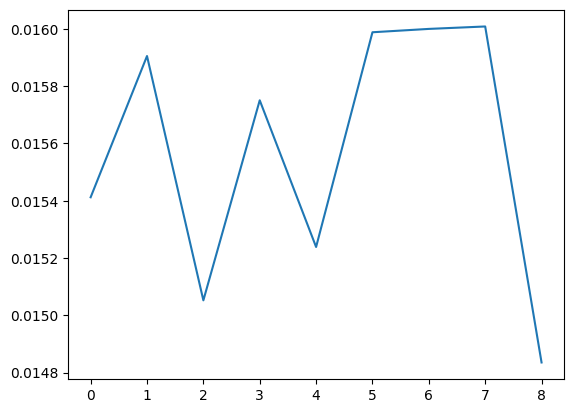

In [26]:
plt.plot(np.array(l2o))#,c = [1, 2, 3, 4, 5, 6, 7, 8, 9])

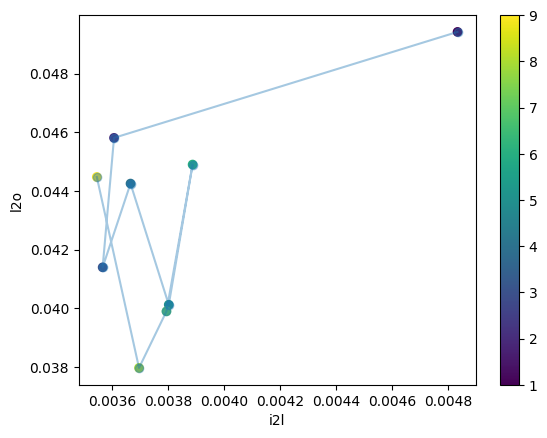

In [16]:
# plt.scatter(x = np.mean(i2l, axis = 1), y = np.array(l2o), c = [1, 2, 3,])
plt.scatter(x = np.mean(i2l, axis = 1), y = np.array(l2o), c = [1, 2, 3, 4, 5, 6, 7, 8, 9])
plt.plot(np.mean(i2l, axis = 1), np.array(l2o), '-o', alpha = 0.4)
plt.xlabel("i2l")
plt.ylabel("l2o")
# plt.title()
plt.colorbar()